In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("proj4.ipynb")

# Project 4: Mongo 

## Due Date: Friday 11/18, 11:59 PM
### Checkpoint: Thursday 11/10, 11:59 PM

In this project, we will be investigating how different database systems handle semi-structured JSON data. In particular, we will be placing emphasis on the use of MongoDB: a database system that stores data in a construct known as documents. These documents are very similar to the JSON objects we've explored in lecture with a few differences in representation and indexing that we will explore in the following questions. In this project, we will be working with the Yelp Academic Dataset which contains a dataset of `businesses`, `reviews`, and `users`. Due to the limitations of JupyterHub and the Mongo instances we are working with, `reviews` and `users` are truncated to 7500 reviews and 1000 users. We will be using the full `businesses` dataset, however.

Throughout the course of this project, you should understand what Mongo can (and cannot) do with regards to its documents as a NoSQL datastore and compare and contrast this to other data representation formats such as the relational model.

## Logistics & Scoring Breakdown

For Data 101 students, this project is worth 15% of your grade. For Info 258 students, this project is worth 12% of your grade.

If you make a non-trivial submission to the **Project 4 \[CHECKPOINT\]** assignment on Gradescope before **Thursday 11/10 11:59PM**, you will earn an extra credit point on this project. We will define "non-trivial" as scoring at least 5 points on the coding portion of the assignment. If you pass all the public tests in Question 1, you are guaranteed to receive the extra credit point. No late submissions will be allowed for the checkpoint.

For the final submission that will be graded, please submit to **Project 4 \[FINAL\]** assignment on Gradescope. Please read the submission instructions carefully and double check that your submission is not throwing any errors.

Each coding question has **both public tests and hidden tests**. Roughly 50% of your coding grade will be made up of your score on the public tests released to you, while the remaining 50% will be made up of unreleased hidden tests. Free-response questions will be manually graded.

This is an **individual project**. However, you’re welcome to collaborate with any other student in the class as long as it’s within the academic honesty guidelines.

Question | Points
--- | ---
1a	| 1
1b  | 1
1c	| 2
1d	| 1
1e	| 2
1f  | 1
2a	| 2
2b	| 1
2c  | 1
2d  | 2
3a	| 1
3b	| 1
3c	| 1
3d  | 1
3e  | 1
3f  | 3
4a	| 1
4b	| 2
4c	| 2
4d  | 1
**Total** | 28

## Loading Up Mongo
We will be using Pymongo, a Python wrapper for MongoDB, for this project. Every student should have access to their own MongoDB instance, running on the localhost of your Datahub server. After running the following cell, for the rest of the project, you can use the Python variables business, review, and user to access the corresponding collection.

In [2]:
import pickle
import pandas as pd
import pymongo
from pymongo import TEXT

myclient = pymongo.MongoClient("mongodb://localhost")
mydb = myclient["yelp"]
business = mydb["business"]
review = mydb["review"]
user = mydb["user"]

## Troubleshooting

**PLEASE READ:** Please avoid printing too much debugging query output - it may crash your Jupyter Hub if your file size becomes too large! It's recommended to delete any debugging query cells if no longer needed as you go through the project.

You might run into issues on the project where you are certain your code works but the output is incorrect. This may be because your collections have been corrupted. Run the following cell and uncomment the specific collections you would like to drop if you would like to remake your collections from scratch. **Be sure to re-run the Load Datasets cells below if you drop your collections so you aren't working with empty collections!**

In [3]:
# UNCOMMENT AND RUN THIS CELL IF YOU WOULD LIKE TO REMAKE YOUR COLLECTIONS FROM SCRATCH. 
# IF YOU DROP ANY COLLECTIONS, RE-RUN THE NEXT TWO CELLS TO LOAD IN THE DATA.

# review.drop()
#business.drop()
# user.drop()

## Load Datasets
The following 2 cells will load the JSON datasets into the appropriate Mongo collections. You will only need to run them once unless you drop the collections above. The second cell **may take a couple of minutes to run** if you are running it for the first time or are running it after you dropped the collections.

In [4]:
import zipfile
import os.path

if not os.path.isfile('data/yelp_academic_dataset_review.json'):
    with zipfile.ZipFile('data/yelp_academic_dataset_review.json.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

if not os.path.isfile('data/yelp_academic_dataset_user.json'):
    with zipfile.ZipFile('data/yelp_academic_dataset_user.json.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

if not os.path.isfile('data/yelp_academic_dataset_business.json'):
    with zipfile.ZipFile('data/yelp_academic_dataset_business.json.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [5]:
# THIS CELL MAY TAKE AT MOST 5 MINUTES. BUT HOPEFULLY YOU WILL ONLY NEED TO RUN IT ONCE.
import json

if business.count_documents({}) == 0:
    print("Loading business collection...")
    with open('data/yelp_academic_dataset_business.json', encoding='utf-8') as f:
        for line in f:
            business.insert_one(json.loads(line))

if review.count_documents({}) == 0:
    print("Loading review collection...")
    with open('data/yelp_academic_dataset_review.json', encoding='utf-8') as f:
        for line in f:
            review.insert_one(json.loads(line))
            
if user.count_documents({}) == 0:
    print("Loading user collection...")
    with open('data/yelp_academic_dataset_user.json', encoding='utf-8') as f:
        for line in f:
            user.insert_one(json.loads(line))

Let's take a quick look at our collections. For the command below, replace `user` with `review` or `business` to count the number of documents in each collection.

In [6]:
user.count_documents({})

1000

Now let's inspect our collections. Replace `business` with `review` and `user` to see the first document in each collection.

In [7]:
business.find_one()

{'_id': ObjectId('638bfe2af1f9cb21ee70614b'),
 'business_id': '6iYb2HFDywm3zjuRg0shjw',
 'name': 'Oskar Blues Taproom',
 'address': '921 Pearl St',
 'city': 'Boulder',
 'state': 'CO',
 'postal_code': '80302',
 'latitude': 40.0175444,
 'longitude': -105.2833481,
 'stars': 4.0,
 'review_count': 86,
 'is_open': 1,
 'attributes': {'RestaurantsTableService': 'True',
  'WiFi': "u'free'",
  'BikeParking': 'True',
  'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
  'BusinessAcceptsCreditCards': 'True',
  'RestaurantsReservations': 'False',
  'WheelchairAccessible': 'True',
  'Caters': 'True',
  'OutdoorSeating': 'True',
  'RestaurantsGoodForGroups': 'True',
  'HappyHour': 'True',
  'BusinessAcceptsBitcoin': 'False',
  'RestaurantsPriceRange2': '2',
  'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",
  'HasTV': 'Tr

If you see a document containing a business named `Oskar Blues Taproom` when you run the command above, it means that our JSON data has successfully been imported into the collection! Now we can get started with exploring Mongo in a bit more detail.

**Todo:** Run the two cells below for grading purposes.

In [8]:
# Do not delete/edit this cell
!mkdir -p results

In [9]:
# Do not delete/edit this cell
import pickle
import pandas as pd

## Question 1: Basic MQL

### Question 1a

In lecture, we discussed how one could find specific attributes from a JSON object using dot notation. 

While you can still use the dot notation in queries, PyMongo represents documents returned from Mongo queries using Python dictionaries, making it convenient to manipulate JSON using a mix of Mongo queries and array indexing. Specifically, given the result of a retrieval `find` query, you can look up the third document by appending `[2]`. Then, given this document, you can look up the field `'amount'` by appending `['amount']` etc., adding multiple square brackets as needed to "walk down" the JSON tree representation via `collection.find(...)[2]['amount']`.

In order to get a visual output of the query results, you will need to wrap `collection.find(...)` inside `list()`, e.g. `list(collection.find(...))`. This is because `collection.find(...)` returns a **Cursor** object, which is an iterator. **An important consequence** is that if we set `result = collection.find(...)`, then calling `list(result)` for the first time will get you the expected list of documents in the query result, but calling `list(result)` for a second time will give you an empty list! So wrapping `collection.find(...)` directly inside `list()` would avoid this issue.

Another note - since we are using Python dictionaries as our query filter, make sure to wrap all keys and values inside quotes.

As a warmup to get you familiarized with PyMongo syntax, find the Tuesday hours for the restaurant named **Legal Sea Foods** at **100 Huntington Ave** in **Boston**. Be careful - there are many Legal Sea Foods in Boston!

In [10]:
result_1a = list(business.find({'name': 'Legal Sea Foods', 'address': '100 Huntington Ave'}, {'hours'}))[0]['hours']['Tuesday']
result_1a

'12:0-21:0'

In [11]:
# Do not delete/edit this cell
pickle.dump(result_1a, open("results/result_1a.p", "wb"))

In [12]:
grader.check("q1a")

q1a results: All test cases passed!

### Question 1b
Now let's get some practice with aggregation and filtering. Our goal is to write a query that computes the average star rating for all businesses in Colorado with 30 reviews or greater. However, this won't be as easy as setting the state to CO! If we inspect this dataset more closely, we will notice that some cities are not matched up with the right states. As an example, run the query below.

In [13]:
list(business.find({"state": "CA"}).limit(3))

[{'_id': ObjectId('638bfe2cf1f9cb21ee706866'),
  'business_id': 'SNCRnaSy6E5fHgQuoCmmbQ',
  'name': 'Katia Photography',
  'address': '',
  'city': 'Portland',
  'state': 'CA',
  'postal_code': '97007',
  'latitude': 45.4501529,
  'longitude': -122.8849111,
  'stars': 5.0,
  'review_count': 11,
  'is_open': 1,
  'attributes': {'BusinessAcceptsBitcoin': 'False',
   'BusinessAcceptsCreditCards': 'True',
   'WiFi': "u'no'"},
  'categories': 'Shopping, Clothing Rental, Event Planning & Services, Fashion, Event Photography, Photographers, Session Photography',
  'hours': {'Monday': '8:0-22:0',
   'Tuesday': '8:0-22:0',
   'Wednesday': '8:0-22:0',
   'Thursday': '8:0-22:0',
   'Friday': '8:0-22:0',
   'Saturday': '8:0-22:0',
   'Sunday': '8:0-22:0'}},
 {'_id': ObjectId('638bfe41f1f9cb21ee70d8d2'),
  'business_id': 'cjwnQMQOGOYgB5uNmiYWLA',
  'name': 'Verizon Authorized Retailer - GoWireless',
  'address': '4655 SW Griffith Dr, Ste 125',
  'city': 'Beaverton',
  'state': 'CA',
  'postal_code'

Notice how cities like Portland and Atlanta, and Orlando are classified as California cities! However, the latitude and longitude is generally correct. The latitude of Colorado is between 37 and 41 **inclusive** and the longitude is between -109 and -102 **inclusive**. Now, use this to **find the average star rating** of all businesses in this range with **30 or more reviews**.

Recall that in SQL, we would use a GROUP BY with the AVG aggregation function. In Mongo, we use an aggregation pipeline, comprised of multiple stages. Each stage transforms the documents in some way. Pipeline stages do not need to produce one output document for every input document. For example, some stages may generate new documents or filter out documents.

**Hint 1**: as in the previous question, you may find it helpful to use the PyMongo array notation to extract the pertinent information once you have composed the right Mongo aggregation query. You are required to wrap `collection.aggregate(...)` inside `list()`, e.g. `list(collection.aggregate(...))` before indexing / visualizing the output. Similar to `collection.find(...)`, `collection.aggregate(...)` also returns a **Cursor** object (which is an iterator).

**Hint 2**: you can set multiple conditions for a given field within the same object, e.g. `{"$gte": 0, "$lte": 10}`. This is the recommended approach, or else you may need to worry about the ordering between the conditions.

In [14]:
result_1b = list(business.aggregate(
    [{'$match': { 'review_count' :  {'$gte': 30}, 'latitude': {'$gte': 37, '$lte': 41}, 
      'longitude': {'$gte': -109, '$lte': -102}}},
     {'$group': {'_id': 'null', 'avgStarRating': {'$avg': '$stars'}}}
    ]))[0]['avgStarRating']
result_1b

3.6735412474849096

In [15]:
# Do not delete/edit this cell
pickle.dump(result_1b, open("results/result_1b.p", "wb"))

In [16]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c

In this question, we will explore aggregation and grouping further. We will also make use of the `$project` operator which allows us to output documents with certain fields of our choosing. 

For this question, we would like to create an aggregation pipeline to find the town in each state with the highest average number of stars. **We will only consider towns with greater than or equal to 5 reviews in total across all the restaurants in that town so that the average is meaningful.** Your final output should contain exactly two fields: `city_state` which is the name of the town with the highest value of average stars in the state concatenated with a comma followed by the state initials and `averageStars` which contains the average number of stars for the corresponding town. To ensure your output is consistent with the autograder, sort in descending order by `averageStars` and break ties by sorting second on `city_state` in alphabetical (ascending) order.

As a concrete example, imagine that Berkeley and Austin have the highest average stars in California and Texas respectively (and both have more than or equal to 5 total reviews). If Berkeley and Austin both have an average star rating of 5.0, your final output should be:

```
{'averageStars': 5.0, 'city_state': 'Austin, TX'}
{'averageStars': 5.0, 'city_state': 'Berkeley, CA'}
```

**Note:** You will provide a pipeline to `business.aggregate(...)` as your solution. Save your pipeline to `q1c_pipeline`.

**Hint:** You may find the `concat` operator helpful. See: https://docs.mongodb.com/manual/reference/operator/aggregation/concat/

In [19]:
q1c_pipeline = [
    {'$group': {'_id': {'state': '$state', 'city': '$city'}, 'sumReview': {'$sum':'$review_count'}, 
                'averageStars': {'$avg': '$stars'}}},
    {'$match': {'sumReview': {'$gte': 5}}},
    {'$sort': {'averageStars':-1}},
    {'$group': {'_id': '$_id.state', 'averageStars': {'$first': '$averageStars'}, 'topCity': {'$first': '$_id.city'}}},
    {'$project': {'_id': 0, 'averageStars': 1, 'city_state': {'$concat': ["$topCity", ', ', '$_id']}}},
    {'$sort': {'averageStars': -1, 'city_state':1}}
]

result_1c = list(business.aggregate(q1c_pipeline))

In [20]:
# Do not delete/edit this cell
result_1c = list(business.aggregate(q1c_pipeline))
pickle.dump(result_1c, open("results/result_1c.p", "wb"))
result_1c

[{'averageStars': 5.0, 'city_state': 'Atlants, GA'},
 {'averageStars': 5.0, 'city_state': 'Bastrop, TX'},
 {'averageStars': 5.0, 'city_state': 'Everett, WA'},
 {'averageStars': 5.0, 'city_state': 'Grove city, OH'},
 {'averageStars': 5.0, 'city_state': 'Irvine, CA'},
 {'averageStars': 5.0, 'city_state': 'Kings County, NY'},
 {'averageStars': 5.0, 'city_state': 'North Portland, OR'},
 {'averageStars': 5.0, 'city_state': 'Oak Bluffs, MA'},
 {'averageStars': 5.0, 'city_state': 'Toronto, ON'},
 {'averageStars': 5.0, 'city_state': 'Vancouver, DC'},
 {'averageStars': 5.0, 'city_state': 'West Point Grey, BC'},
 {'averageStars': 5.0, 'city_state': 'lake mary, FL'},
 {'averageStars': 4.5, 'city_state': 'Jamestown, CO'},
 {'averageStars': 4.5, 'city_state': 'Portland, HI'},
 {'averageStars': 4.5, 'city_state': 'Powell, DE'},
 {'averageStars': 4.5, 'city_state': 'Salem, AZ'},
 {'averageStars': 4.5, 'city_state': 'Vancouver, ABE'},
 {'averageStars': 4.0, 'city_state': 'Franklin Park, IL'},
 {'avera

In [21]:
grader.check("q1c")

q1c results: All test cases passed!

### Question 1d

In class, we've described structured (rectangular) data as well as semi-structured data. We haven't quite covered unstructured data -- this is basically free-form text. Often, in semi-structured JSON you may have unstructured text data embedded within, such as the text field in the review collection.

MongoDB allows us to build a so-called **text index** to retrieve the relevant document based on keywords found in text in a predefined field. This index converts our free-form text into a structure that allows us to easily look up documents by its contents. To leverage this text search capability, we build a text index on the `text` field in the `review` collection. This has been done for you.

We will then use this text index to do basic sentiment analysis and find all the restaurants we should avoid! Using the text index given, write a query to find all the reviews with "disgusting", "horrible", "horrid", "gross", "bad", or "hate". To use the text index, use the keywords `$text` and `$search` as detailed here: https://www.mongodb.com/docs/manual/core/text-search-operators/.

Fill in your query into `result_1d` to count how many reviews contain any of these 6 words.

**Hint:** In general, you can count the number of documents returned by a `find` query result via `len(list(collection.find(...)))` or more simply `collection.count_documents(...)`. To count the number of documents returned by an `aggregate` query result, the best way is to directly use `len(list(collection.aggregate(...)))`.

In [22]:
# We create a text index here
if 'text_text' not in review.index_information():
    review.create_index([('text', TEXT)])

result_1d = len(list(review.find(
    {'$text': {'$search': "disgusting horrible horrid gross bad hate"}}
)))
result_1d

728

In [23]:
# Do not delete/edit this cell
pickle.dump(result_1d, open("results/result_1d.p", "wb"))

In [24]:
grader.check("q1d")

q1d results: All test cases passed!

### Question 1e

Now let's learn Mongo updates, deletions, and creation. Create a new collection called `review_boolean` which is the exact same as `reviews` EXCEPT there is a new field called `to_avoid` which is the string "true"  if the review `text` contains the words "disgusting", "horrid", "horrible", "gross", "bad", or "hate" and the string "false" if not.  

This is a tricky task! We have not discussed creation, updates, or insertions in great detail during lecture but luckily, Mongo uses a similar approach to SQL.

*Insertions*: In order to insert into a document, you may use the functions [review_boolean.insert_one(...)](https://docs.mongodb.com/manual/reference/method/db.collection.insertOne/) or [review_boolean.insert_many(...)](https://docs.mongodb.com/manual/reference/method/db.collection.insertMany/). These functions take in a document or a list of documents and inserts them into the collection. 

*Updates*: In order to update a document, you may use the functions [review_boolean.update_one(...)](https://docs.mongodb.com/manual/reference/method/db.collection.updateOne/) or [review_boolean.update_many(...)](https://docs.mongodb.com/manual/reference/method/db.collection.updateMany/). These functions take in two parameters. The first specifies which documents should be modified. If the first parameter is `{}`, this indicates that all documents should be updated. However, you can put a more specific filter here if you would like. The second parameter specifies what you would like to update your field to (the [$set](https://docs.mongodb.com/manual/reference/operator/update/set/) operator may come in handy here). Recall that in our SQL model, updates are performed as `UPDATE ... SET ... WHERE ...`. In our case, the first ellipsis corresponds to `review_boolean`, the second ellipsis corresponds to the second parameter of `update_*`, and the third ellipsis corresponds to the first parameter of `update_*`.

*Creation*: We handle creation of the collection for you. But in Pymongo, creation of a collection is as simple as writing `variable_name = db[collection_name]` where db is the the Pymongo database object variable you have already created.

Some additional reminders and hints:
- The empty collection `review_boolean` has already been created for you and is stored in the variable of the same name.
- A text index has been created for you. You can use a similar search approach as the last question.
- We want to start by inserting the documents from the `review` collection into the `review_boolean` collection.
- Don't forget that in order to pass the hidden tests, the `to_avoid` field must exist for every document in `review_boolean`! The [$exists](https://www.mongodb.com/docs/manual/reference/operator/query/exists/) operator may be helpful.

In [25]:
review_boolean = mydb["review_boolean"]
review_boolean.drop()

# We create a text index here
if 'text_text' not in review_boolean.index_information():
    review_boolean.create_index([('text', TEXT)])

review_boolean.insert_many([i for i in list(review.find())])
review_boolean.update_many(
{'$text': {'$search': "disgusting horrible horrid gross bad hate"}},
{'$set': {'to_avoid': "true"}})
review_boolean.update_many(
    {'to_avoid': {'$exists': False}}, 
    {"$set":{'to_avoid':'false'}});

In [26]:
# Do not delete/edit this cell
review_boolean_1e = mydb["review_boolean"]
pickle.dump(list(review_boolean_1e.find({}, {'_id': 0})), open("results/result_1e.p", "wb"))

In [27]:
grader.check("q1e")

q1e results: All test cases passed!

### Question 1f

Now, you had a change of heart: you decide that it's unfair to label restaurants as `to_avoid` without at least giving them a chance! Remove the `to_avoid` field from the `review_boolean` collection. Calculate the `difference` between the data size of `review_boolean` with the `to_avoid` field and without it. The code for making this calculation is provided but it is up to you to actually remove the field.

*Deletions*: Deletions in Mongo make use of the `review_boolean.update_one(...)` or `review_boolean.update_many(...)` functionality discussed in Question 1e. However, this time, instead of using the `$set` operator which allows for the creation of new fields, we will use the [$unset](https://docs.mongodb.com/manual/reference/operator/update/unset/) operator which deletes them! Very tidy!

**Before running the next cell, make sure to re-run your cell for 1e so you don't get a difference of 0!**

In [28]:
with_avoid = mydb.command("collstats", "review_boolean")['size']

# YOUR ANSWER BEGINS HERE
review_boolean.update_many({}, {'$unset': {'to_avoid': ""}}
)
# END

without_avoid = mydb.command("collstats", "review_boolean")['size']
difference = with_avoid - without_avoid
difference

149272

In [29]:
# Do not delete/edit this cell
pickle.dump(difference, open("results/result_1f.p", "wb"))

In [30]:
grader.check("q1f")

q1f results: All test cases passed!

## Question 2: JSON and Relational Models

### Question 2a

Now we have a good idea of how to do retrieval, aggregation, and updates in Mongo. But we haven't talked about why we
would want to use Mongo to store JSON! In order to explore this, let's take another look at the `business`
collection. We will look at the first two entries.

In [31]:
list(business.find({}).limit(2))

[{'_id': ObjectId('638bfe2af1f9cb21ee70614b'),
  'business_id': '6iYb2HFDywm3zjuRg0shjw',
  'name': 'Oskar Blues Taproom',
  'address': '921 Pearl St',
  'city': 'Boulder',
  'state': 'CO',
  'postal_code': '80302',
  'latitude': 40.0175444,
  'longitude': -105.2833481,
  'stars': 4.0,
  'review_count': 86,
  'is_open': 1,
  'attributes': {'RestaurantsTableService': 'True',
   'WiFi': "u'free'",
   'BikeParking': 'True',
   'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
   'BusinessAcceptsCreditCards': 'True',
   'RestaurantsReservations': 'False',
   'WheelchairAccessible': 'True',
   'Caters': 'True',
   'OutdoorSeating': 'True',
   'RestaurantsGoodForGroups': 'True',
   'HappyHour': 'True',
   'BusinessAcceptsBitcoin': 'False',
   'RestaurantsPriceRange2': '2',
   'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casua

<!-- BEGIN QUESTION -->

What are **two** pros of storing this data in MongoDB with JSON over a relational database management system such as Postgres?
Please reference specific examples from the `business` collection to back up your claims. 

<!--
BEGIN QUESTION
name: q2a
manual: true
points: 2
-->

One benefit of storing this data in MongoDB over Postgres is that the NOSQL databses have more storage flexibility. For instance, the business collection consists of multiple documents as each document is handled as an individual object where there is no fixed schema as you can evolve your data to adapt it if there is additional information to store. The business collection shows this above by including additional fields such as 'Caters','RestaurantsReservations', and'RestaurantsDelivery' which are not there for the first entry in the business collection. This shows how the storage can be flexible for each individual object without affecting any other document.

Another benefit of storing this data in MongoDB is the schema flexibility especially through its ability of nesting data structures through nested arrays or embedding and the ease at which that data can be queried. In the business collection, the hours of opening for each day of the week are stored as an array of strings in the field "hours" and if we want to get the hours of operation for a specific day we would do so with minimal steps as compared to a complex SQL query that is required by an RDMS such as Postgres. After using .find and searching for the restaurant name, we would simply need to put that result in a list form and access the elements we need similar to a python dictionary. 

<!-- END QUESTION -->



### Question 2b

It seems like MongoDB is getting all the love when it comes to JSON support! However, modern iterations of relational databases
such as Postgres 9.3+ also have [excellent JSON functionality](https://www.postgresql.org/docs/9.3/functions-json.html) as we will soon explore in this task. First, let's set up a
bit of scaffolding. The following cell will import the `yelp_academic_dataset_review.json` data into a table called `reviews` in Postgres yelp database.

In [32]:
%reload_ext sql
%sql postgresql://jovyan@127.0.0.1:5432/postgres

!psql -h localhost -c 'DROP DATABASE IF EXISTS yelp'
!psql -h localhost -c 'CREATE DATABASE yelp'
!psql -h localhost -d yelp -c 'DROP TABLE IF EXISTS reviews'
!psql -h localhost -d yelp -c 'CREATE TABLE reviews(data TEXT);'
!cat data/yelp_academic_dataset_review.json | psql -h localhost -d yelp -c "COPY reviews (data) FROM STDIN;"
%sql \l

DROP DATABASE
CREATE DATABASE
NOTICE:  table "reviews" does not exist, skipping
DROP TABLE
CREATE TABLE
COPY 7500
 * postgresql://jovyan@127.0.0.1:5432/postgres
8 rows affected.


Name,Owner,Encoding,Collate,Ctype,Access privileges
baseball,jovyan,UTF8,en_US.utf8,en_US.utf8,None
imdb,jovyan,UTF8,en_US.utf8,en_US.utf8,None
jovyan,jovyan,UTF8,en_US.utf8,en_US.utf8,None
postgres,jovyan,UTF8,en_US.utf8,en_US.utf8,None
template0,jovyan,UTF8,en_US.utf8,en_US.utf8,=c/jovyanjovyan=CTc/jovyan
template1,jovyan,UTF8,en_US.utf8,en_US.utf8,=c/jovyanjovyan=CTc/jovyan
ucb_buildings,jovyan,UTF8,en_US.UTF-8,en_US.UTF-8,None
yelp,jovyan,UTF8,en_US.utf8,en_US.utf8,None


Now, run the following cell to connect to the Postgres yelp database. There should be no errors after running the following cell.

In [33]:
%sql postgresql://jovyan@127.0.0.1:5432/yelp

Run the following cell to observe how this new `reviews` table looks. Note that the `data` column is stored as TEXT and not as JSON.

In [34]:
%%sql
SELECT * FROM reviews LIMIT 2;

   postgresql://jovyan@127.0.0.1:5432/postgres
 * postgresql://jovyan@127.0.0.1:5432/yelp
2 rows affected.


data
"{""review_id"":""lWC-xP3rd6obsecCYsGZRg"",""user_id"":""ak0TdVmGKo4pwqdJSTLwWw"",""business_id"":""buF9druCkbuXLX526sGELQ"",""stars"":4.0,""useful"":3,""funny"":1,""cool"":1,""text"":""Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. After reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and grana frita. Both were very good. We split a secondi which was the special Berkshire pork secreto, which was described as a pork skirt steak with garlic potato purée and romanesco broccoli (incorrectly described as a romanesco sauce). Some tables received bread before the meal but for some reason we did not. Management also seems capable for when the tenants in the apartment above began playing basketball she intervened and also comped the tables a dessert. We ordered the apple dumpling with gelato and it was also quite tasty. Portions are not huge which I particularly like because I prefer to order courses. If you are someone who orders just a meal you may leave hungry depending on you appetite. Dining room was mostly younger crowd while the bar was definitely the over 40 set. Would recommend that the naysayers return to see the improvement although I personally don't know the former glory to be able to compare. Easy access to downtown Salem without the crowds on this month of October."",""date"":""2014-10-11 03:34:02""}"
"{""review_id"":""8bFej1QE5LXp4O05qjGqXA"",""user_id"":""YoVfDbnISlW0f7abNQACIg"",""business_id"":""RA4V8pr014UyUbDvI-LW2A"",""stars"":4.0,""useful"":1,""funny"":0,""cool"":0,""text"":""This store is pretty good. Not as great as Walmart (or my preferred, Milford Target), but closer and in a easier area to get to. The store itself is pretty clean and organized, the staff are friendly (most of the time), and BEST of all is the Self Checkout this store has! Great clearance sections throughout, and great prices on everything in the store, in general (they pricematch too!). Christian, Debbie, Jen and Hanna are all very friendly, helpful, sensitive to all customer needs. Definitely one of the better Target locations in the area, and they do a GREAT job assisting customers for being such a busy store. Located directly in the Framingham Mall on Cochituate Rd / Route 30. 4 stars."",""date"":""2015-07-03 20:38:25""}"


Observe how the reviews table consists of one column named `data`. This column contains all the JSON documents in the 
reviews collection *in text format*. Use [Postgres' JSON functions](https://www.postgresql.org/docs/9.3/functions-json.html) to write a query that converts the JSON fields into their own `TEXT` columns (hint: one of the operators in Table 9-40 may be useful). To be more concrete, your query should contain 8 columns in this particular order: `review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, and `text`. Each row should correspond to one JSON document. Some skeleton code (that does the mundane work of converting data to JSON properly) is provided to you - you will only need to fill in the SELECT clause.

In [35]:
%%sql result_2b <<
SELECT values ->> 'review_id' as review_id, values ->> 'user_id' as user_id, values ->> 'business_id' as business_id,
values ->> 'stars' as stars, values ->> 'useful' as useful, values ->> 'funny' as funny, values ->> 'cool' as cool,
values ->> 'text' as text
FROM (SELECT CAST(regexp_replace(data, E'[\\n\\r]+', '','g') AS JSON) AS values FROM reviews) b
ORDER BY review_id
LIMIT 10;

   postgresql://jovyan@127.0.0.1:5432/postgres
 * postgresql://jovyan@127.0.0.1:5432/yelp
10 rows affected.
Returning data to local variable result_2b


In [36]:
result_2b

review_id,user_id,business_id,stars,useful,funny,cool,text
000bviMESLXmlIFKDzCEfw,f7LnyAbhP5OSXvv_xiuZhw,SNuCspoI3HKcwJpZL5FcjQ,3.0,2,0,0,"I went there not having read any reviews. From the outside it looked nice but the inside isn't nice at all...not sure why people are saying it is. I didn't have an appointment but they took me anyways, which was nice. I just got a manicure and it was minimal. I mean that I washed my hands, she pushed back my cuticles and trimmed them and got started painting...then when she was done that was it. My nails look pretty good although the sides were not fully painted. Even though my nails look good I am not sure I would go back because getting your nails done should be a luxurious time to relax and get pampered. I often find that if things say, luxury or upscale they are really not. The overall look of the place was dirty and I wouldn't want to get my toes done here because it looked uncomfortable and not that clean. Both women that were there were very nice and I appreciated that very much."
003VeQn6SrVQS4sYHlc0gg,ba8ZSYE11LVepGCxwP9Vpg,rdS7hBBeukiX4Led9OT8sg,5.0,0,0,0,"Molana has one of the most tender Chicken Bargs I have ever had in my life! (and I have had alot of them) So delicious, beautifully seasoned, and super tender. We also got the Koubideh, that was also well seasoned, was cooked well, and was still juicy and tender. And last, but not least, the Ghorme Sabzi was so great. The strew could use a little more beans, but it was so well-cooked and tasted like those you'd have at your mom's or auntie's house Keep up the great work, Molana!"
00HovWV7VcZZPx5IleoeWA,Nzaq0bJcE3q_bRdFrsFRsA,Ln-8CbKGZGmF-GCqMoMcpA,4.0,0,0,0,"This place is really new, but they were pretty busy during my visit, loved the experience. The design is very open, clean, and inviting, they appear to support a beach theme. The staff is dressed in white to complement the airy vibe. What I noticed immediately is the friendliness-everyone seemed so happy and upbeat. I loved that.The food was also very very good. I thought the guac and corn tortillas were really good and also the chicken bowl with brown rice was very flavorful. You can taste the fresh cilantro prevalent in a lot of their dishes.I had a margarita (okay 3 margaritas lol) that was honestly one of the best I've had in a really really long time. They have high quality aged tequila and use fresh squeezed juices for every drink. Don't miss out on their cocktail selections. I'm impressed and look forward to returning."
00pmZ82_w6Mpky6dl2jpiA,r7e-6OS8A_gE_0CTUjQR3g,IDxaD_0_9TlWyKKXBFwjMA,1.0,0,0,0,The food was great .. we had breakfast... the service needs some work... we had to ask for everything ... hopefully the waitress was just new Gave it a second try. Service is crap. Will not go back
021UtGruSN1RA5YRS92E7w,6cyn5sP2OCarYV02KWtuGQ,5HMXgD_gui5n0Tc_hadesg,3.0,0,0,0,The atmosphere is great for drinks but I'd say its a little overpriced for what it is. The poutine is good and worth it. I got the rabbit tacos and the rabbit was a little grainy and the tacos were basic. I think they could have been better.
03lRn8FzfnMojQvCvYmPfg,HUiCXGr6u91zQ6RppIpPdg,slBGJOdBV1KHzNoWf2e2FQ,2.0,0,0,0,"This place is a so-so. The service is ok. We got a vegetarian pho bowl and got a bowl with just noodles. This was the second time we went. The first time we went, we got the same thing and it came with a few veggies. Keep in mind that that's literally the price as a bowl of pho with beef. Also, we ordered a cup of iced tea, and got a cup of lemon flavoured water. There was not much flavour, and it definitely didn't taste like iced tea. So I guess it depends when you go."
03V4Y5Yql2T7_Fs186Fbfg,mpDCL8ZtHh6hbH_JfHPL2w,CCK1fCaqCC8LUWu5tRCbmg,3.0,0,0,0,"Food is ok, seemed like too many veggies and not enough protein. After the extra rice charge, a small lunch was $9...which is too high!!"
04dUiVd_qE8K289SZdliyg,iwvndJ05-Q5KjSsHhjNKOw,24bxH8U1DRu1biUYaaEv8w,4.0,0,0,0,"I recently tried Hound D

In [37]:
# Do not delete/edit this cell
result_2b.DataFrame().to_csv('results/result_2b.csv', index=False)

In [38]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c

One important aspect of data engineering that we have not referred to yet are joins. We saw, through the use of indices, selection/projection pushdown, and various physical implementations (as well as orderings), joins could be done quite efficiently in relational SQL based databases. How do joins fare in Mongo where the data stored is inherently semistructured? Let's investigate! For this question, we have provided you access to the tables `business_complete` and `review_complete` which contain the business and review collections in relational form as described in 2b (the columns of the relations
are fields in the JSON document). Each relation has its respective id (`business_id` or `review_id`) column as its primary key.

In [39]:
!psql -h localhost -d yelp -c 'DROP TABLE IF EXISTS business_complete'
!psql -h localhost -d yelp -c 'CREATE TABLE business_complete(business_id TEXT PRIMARY KEY, name TEXT, address TEXT, city TEXT, state TEXT, postal_code TEXT, latitude TEXT,longitude TEXT, stars TEXT, review_count TEXT, is_open TEXT, attributes TEXT, categories TEXT, hours TEXT);'
!psql -h localhost -d yelp -c 'DROP TABLE IF EXISTS review_complete'
!psql -h localhost -d yelp -c 'CREATE TABLE review_complete(review_id TEXT PRIMARY KEY, user_id TEXT, business_id TEXT, stars TEXT, useful TEXT, funny TEXT, cool TEXT,text TEXT);'
!cat data/business.csv | psql -h localhost -d yelp -c "COPY business_complete (business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours) FROM STDIN CSV HEADER;"
!cat data/review.csv | psql -h localhost -d yelp -c "COPY review_complete (review_id, user_id, business_id, stars, useful, funny, cool, text) FROM STDIN CSV HEADER;"

NOTICE:  table "business_complete" does not exist, skipping
DROP TABLE
CREATE TABLE
NOTICE:  table "review_complete" does not exist, skipping
DROP TABLE
CREATE TABLE
COPY 35
COPY 7500


Let's take a look at how `review_complete` looks.

In [40]:
%%sql
SELECT * FROM review_complete LIMIT 1;

   postgresql://jovyan@127.0.0.1:5432/postgres
 * postgresql://jovyan@127.0.0.1:5432/yelp
1 rows affected.


review_id,user_id,business_id,stars,useful,funny,cool,text
lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,"Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. After reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and grana frita. Both were very good. We split a secondi which was the special Berkshire pork secreto, which was described as a pork skirt steak with garlic potato purée and romanesco broccoli (incorrectly described as a romanesco sauce). Some tables received bread before the meal but for some reason we did not. Management also seems capable for when the tenants in the apartment above began playing basketball she intervened and also comped the tables a dessert. We ordered the apple dumpling with gelato and it was also quite tasty. Portions are not huge which I particularly like because I prefer to order courses. If you are someone who orders just a meal you may leave hungry depending on you appetite. Dining room was mostly younger crowd while the bar was definitely the over 40 set. Would recommend that the naysayers return to see the improvement although I personally don't know the former glory to be able to compare. Easy access to downtown Salem without the crowds on this month of October."


At this current moment in time, Mongo only supports left joins (via the lookup aggregation stage). This is what we will compare against SQL.

Let's start by writing a SQL query that displays all the reviews along with their associated business information. You should perform a **left join** between the `review_complete` table and the `business_complete` table on the `business_id` column, and you may project all columns. Keep a mental note of the **execution time** that you see in the query plan.

In [41]:
result_2c_str = 'SELECT * FROM review_complete LEFT JOIN business_complete ON review_complete.business_id = business_complete.business_id'
!psql -h localhost -d yelp -c "explain analyze $result_2c_str"

                                                         QUERY PLAN                                                          
-----------------------------------------------------------------------------------------------------------------------------
 Hash Left Join  (cost=13.82..778.08 rows=15792 width=704) (actual time=0.163..4.603 rows=7500 loops=1)
   Hash Cond: (review_complete.business_id = business_complete.business_id)
   ->  Seq Scan on review_complete  (cost=0.00..721.92 rows=15792 width=256) (actual time=0.006..2.368 rows=7500 loops=1)
   ->  Hash  (cost=11.70..11.70 rows=170 width=448) (actual time=0.132..0.135 rows=35 loops=1)
         Buckets: 1024  Batches: 1  Memory Usage: 32kB
         ->  Seq Scan on business_complete  (cost=0.00..11.70 rows=170 width=448) (actual time=0.071..0.082 rows=35 loops=1)
 Planning Time: 0.739 ms
 Execution Time: 5.032 ms
(8 rows)



Now, let's perform the equivalent left join in Mongo between `review` and `business`. **The output array field should be named as `business_info`**. Feel free to refer to the `$lookup` documentation: https://docs.mongodb.com/manual/reference/operator/aggregation/lookup/.

**Note:** You will provide a single-stage pipeline to `review.aggregate(...)` as your solution. Save your pipeline to `q2c_pipeline`.

In [42]:
# We first create an index on business_id in the business collection
business.create_index('business_id', unique=True)

q2c_pipeline = [
{'$lookup': {'from': 'business', 'localField': 'business_id', 'foreignField': 'business_id', 'as': 'business_info'}}
]

result_2c = list(review.aggregate(q2c_pipeline))[:5]
result_2c

[{'_id': ObjectId('636c02011ef0d3dc579924f4'),
  'review_id': 'lWC-xP3rd6obsecCYsGZRg',
  'user_id': 'ak0TdVmGKo4pwqdJSTLwWw',
  'business_id': 'buF9druCkbuXLX526sGELQ',
  'stars': 4.0,
  'useful': 3,
  'funny': 1,
  'cool': 1,
  'text': "Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. \n\nAfter reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tag

In [43]:
# Do not delete/edit this cell
result_2c = list(review.aggregate(q2c_pipeline))[:5]
pickle.dump(result_2c, open("results/result_2c.p", "wb"))

In [44]:
grader.check("q2c")

q2c results: All test cases passed!

Run the following cell to examine the query plan for the Mongo query that you just wrote. Again, make a mental note of the execution time that you see (you can find the value corresponding to the key `executionTimeMillis`).

In [45]:
mydb.command('explain', {'aggregate': 'review', 'pipeline': q2c_pipeline, 'cursor': {}}, verbosity='executionStats')

{'explainVersion': '1',
 'stages': [{'$cursor': {'queryPlanner': {'namespace': 'yelp.review',
     'indexFilterSet': False,
     'parsedQuery': {},
     'queryHash': '8B3D4AB8',
     'planCacheKey': 'D542626C',
     'maxIndexedOrSolutionsReached': False,
     'maxIndexedAndSolutionsReached': False,
     'maxScansToExplodeReached': False,
     'winningPlan': {'stage': 'COLLSCAN', 'direction': 'forward'},
     'rejectedPlans': []},
    'executionStats': {'executionSuccess': True,
     'nReturned': 7500,
     'executionTimeMillis': 772,
     'totalKeysExamined': 0,
     'totalDocsExamined': 7500,
     'executionStages': {'stage': 'COLLSCAN',
      'nReturned': 7500,
      'executionTimeMillisEstimate': 0,
      'works': 7502,
      'advanced': 7500,
      'needTime': 1,
      'needYield': 0,
      'saveState': 10,
      'restoreState': 10,
      'isEOF': 1,
      'direction': 'forward',
      'docsExamined': 7500}}},
   'nReturned': 7500,
   'executionTimeMillisEstimate': 10},
  {'$lookup

<!-- BEGIN QUESTION -->

### Question 2d

In the last question, you performed equivalent left joins in both Postgres and Mongo, and examined their query plans. Which join was faster? What gives that database system you chose an advantage over the other?
<!--
BEGIN QUESTION
name: q2d
manual: true
points: 2
-->

The left join in Postgres was faster (7.616 ms vs 826 ms). The MongoDB left join was very poor compared to the Postgres one because join require creating more complex data and the performance with MongoDB drops off heavily compared to joins with PostgreSQL which is more suited to handling more complex structured data. The Postgres database system has an advantage because it can use multiple join tactics such as merge join and hash join and will pick the best strategy through better indexing frameworks while MongoDB is constrained to a single strategy of iterating through every field of each document within a JSON collection which is taxing and offers poor performance

<!-- END QUESTION -->



## Question 3: Dataframes / Pandas

### Question 3a

So far, we've talked about NoSQL / document databases like Mongo and relational databases like Postgres. Now, we will explore data transformation with a different data model: dataframes. Dataframes are similar to relations with some differences as we will dive into here. To that end, we will use Pandas which is a Python package that allows you to work with dataframes. Pandas is widely adopted by data scientists for data loading, wrangling, cleaning, and analysis. To start, let us export our MongoDB collections into Pandas using a function called `json_normalize`. We need to truncate
`business` before we can use it to meet the memory constraints set by Jupyter. The variable `business_trunc` will contain the reference the truncated business collection.

In [46]:
business_trunc = mydb["business_trunc"]
count = 0
if business_trunc.count_documents({}) != 1000:
    for document in business.find({}):
        count += 1
        business_trunc.insert_one(document)
        if count == 1000:
            break

business_cursor = business_trunc.find({})
review_cursor = mydb["reviews"].find({})
user_cursor = mydb["users"].find({})

# Load the collections into Pandas. 
from pandas import json_normalize
user_df = json_normalize(user_cursor)
review_df = json_normalize(review_cursor)
business_df = json_normalize(business_cursor)

For the rest of Question 3, please use the 3 dataframes we just created: `user_df`, `review_df`, and `business_df`. Let's take a look at the first 5 rows of `business_df`.

In [47]:
business_df.head()

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,attributes.GoodForDancing,attributes.BestNights,attributes.Music,attributes.BYOB,attributes.CoatCheck,attributes.Smoking,attributes.DriveThru,attributes.BYOBCorkage,attributes.Corkage,attributes.RestaurantsCounterService
0,636c019f1ef0d3dc5796b1ab,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,636c019f1ef0d3dc5796b1ac,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,636c019f1ef0d3dc5796b1ad,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,636c019f1ef0d3dc5796b1ae,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,636c019f1ef0d3dc5796b1af,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<!-- BEGIN QUESTION -->

What do you notice about how the columns of `business_df` are constructed? Compare and contrast this dataframe representation with the document representation we saw with Mongo.

<!--
BEGIN QUESTION
name: q3a
manual: true
points: 1
-->

Each entry in the business_df dataframe have built in indexes for each entry in the dataframe along with having a value for each column in the dataframe. The "missing" values for each column are still reprsented by a null value in the pandas dataframe. On the other hand, MongoDB does not have any specific indexes for each field and some documents in each collection may not have values for some fields that other documents in the collection may have as the structure is flexible and semi-structured so this is allowed. Another important idea is that a nested values within a pandas dataframe are possible but represent bad structure because all of the values cannot be read from a dataframe form if there are too many while MongoDB lets you have arrays for values of fields with ease and readability.

<!-- END QUESTION -->



### Question 3b

In the previous question, we talked about how Mongo and Postgres approach joins. Pandas is also capable of performing joins using the [merge()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) function! For this task, perform a inner join on `business_df` with itself on `stars`. The final dataframe should be saved to a variable called `result_3b` and should only contain 3 columns in this particular order: the name of the first restaurant, the name of the second restaurant, and the number of the stars. The column names can be arbitrary.

**Hint:** Check out [this tutorial](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html) on selecting a subset of the Dataframe. This will be helpful in the rest of Question 3 as well!

In [62]:
result_3b = business_df.merge(business_df, how = 'inner', on = 'stars')[['name_x', 'name_y', 'stars']]
result_3b

,name_x,name_y,stars
0,Oskar Blues Taproom,Oskar Blues Taproom,4.0
1,Oskar Blues Taproom,Flying Elephants at PDX,4.0
2,Oskar Blues Taproom,Crossfit Terminus,4.0
3,Oskar Blues Taproom,Capital City Barber Shop,4.0
4,Oskar Blues Taproom,Star Kreations Salon and Spa,4.0
...,...,...,...
153959,White Egret Farm,Bluffs at Town Lake,1.5
153960,White Egret Farm,Taco Cabana,1.5
153961,White Egret Farm,Shaws,1.5
153962,White Egret Farm,Steak ’n Shake,1.5


In [63]:
# Do not delete/edit this cell
result_3b.columns = ['first', 'second', 'stars']
result_3b.sort_values(['first', 'second', 'stars'])[:50].to_csv('results/result_3b.csv', index=False)

In [64]:
grader.check("q3b")

q3b results: All test cases passed!

### Question 3c

Due to the nested representation of the data, there are a lot of missing fields with NaN values in the `business_df` dataframe as you may have noticed in 3a. Construct a dataframe `missing_value_df` with two columns: `column_name` and `percent_missing`. `percent_missing` should be the percentage of NaN values in the corresponding column in `business_df`.

**Hint:** use Pandas' [isnull()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html) function followed by sum().

In [65]:
percent_missing = business_df.isnull().sum() * 100 / len(business_df)
missing_value_df = pd.DataFrame({'column_name': business_df.columns,'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
_id,_id,0.0
business_id,business_id,0.0
name,name,0.0
address,address,0.0
city,city,0.0
state,state,0.0
postal_code,postal_code,0.0
latitude,latitude,0.0
longitude,longitude,0.0
stars,stars,0.0


In [66]:
# Do not delete/edit this cell
missing_value_df.to_csv('results/result_3c.csv', index=False)

In [67]:
grader.check("q3c")

q3c results: All test cases passed!

### Question 3d

Plot a histogram distribution of the percentage of NaN values across all columns (via Pandas [hist()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) function). Don't worry about putting titles / making it look nice - we won't be grading the plot.

array([[<AxesSubplot:title={'center':'percent_missing'}>]], dtype=object)

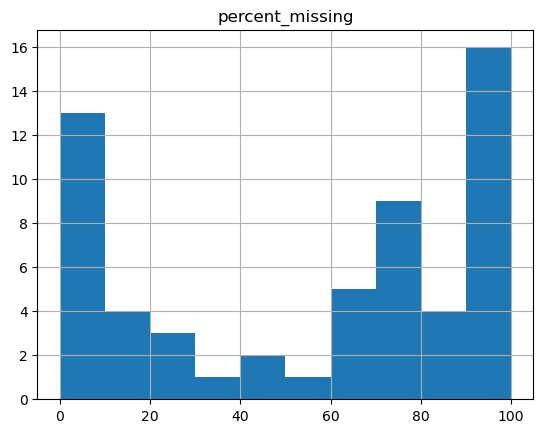

In [68]:
missing_value_df.hist()

Examine the histogram that you just plotted. How many columns are 90%+ NaN? Input your answer into `result_q3d` as an integer (e.g. if your answer is 6, then `result_q3d = 6`)

<!--
BEGIN QUESTION
name: q3d
points: 1
-->

In [69]:
result_q3d = 16

In [70]:
grader.check("q3d")

q3d results: All test cases passed!

### Question 3e

Let us now alter `business_df` to exclude the columns with more than 80%+ null values (keep columns with 80% null values or less). This likely means the corresponding attributes are not an important factor for most businesses so we can get rid of them in our `business_df`. Create a new dataframe called `important_attribute_business_df` which only contains these columns.

**Hint:** check out [this section](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html#how-do-i-select-specific-rows-and-columns-from-a-dataframe) from the tutorial linked in Q3b.

In [71]:
keep = missing_value_df.loc[missing_value_df['percent_missing'] <= 80.0]['column_name']
important_attribute_business_df = business_df[keep]
important_attribute_business_df

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,attributes.RestaurantsDelivery,hours.Monday,hours.Tuesday,hours.Wednesday,hours.Thursday,hours.Friday,hours.Saturday,hours.Sunday,attributes.GoodForKids,attributes.ByAppointmentOnly
0,636c019f1ef0d3dc5796b1ab,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,None,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,NaN,NaN
1,636c019f1ef0d3dc5796b1ac,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,...,False,5:0-18:0,5:0-17:0,5:0-18:0,5:0-18:0,5:0-18:0,5:0-18:0,5:0-18:0,True,False
2,636c019f1ef0d3dc5796b1ad,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,...,NaN,NaN,NaN,NaN,11:0-18:0,11:0-18:0,11:0-18:0,11:0-18:0,NaN,False
3,636c019f1ef0d3dc5796b1ae,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
4,636c019f1ef0d3dc5796b1af,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,...,NaN,16:0-19:0,16:0-19:0,16:0-19:0,16:0-19:0,16:0-19:0,9:0-11:0,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,636c01a01ef0d3dc5796b58e,HQ1fwOWzYK5zSxTGSwSvmw,Dunkin',99 Cambridge St,Charlestown,MA,02129,42.382539,-71.079236,2.0,...,True,5:0-23:0,5:0-23:0,5:0-23:0,5:0-23:0,5:0-23:0,5:0-23:0,5:0-23:0,True,False
996,636c01a01ef0d3dc5796b58f,LOiS95cRQbPrbRZ2-fMXbg,Shane's Rib Shack,1221 Caroline St,Atlanta,GA,30307,33.758258,-84.348474,3.0,...,True,11:0-21:0,11:0-21:0,11:0-21:0,11:0-21:0,11:0-21:0,11:0-21:0,11:0-21:0,True,NaN
997,636c01a01ef0d3dc5796b590,9irir2PpYr_yY5lNWYqUWA,Subaru North Orlando,4113 S Orlando Dr,Sanford,FL,32773,28.749161,-81.291087,4.0,...,NaN,10:0-18:0,8:30-20:0,8:30-20:0,8:30-20:0,8:30-20:0,8:30-18:0,NaN,NaN,False
998,636c01a01ef0d3dc5796b591,2cG2YiR8Tg-YCJJfaHJtYw,Elements Massage - Medford,40 High St,Medford,MA,02155,42.418388,-71.111116,4.0,...,NaN,9:0-21:0,9:0-21:0,9:0-21:0,9:0-21:0,9:0-21:0,9:0-21:0,9:0-21:0,NaN,False


In [72]:
# Do not delete/edit this cell
important_attribute_business_df.to_csv('results/result_3e.csv', index=False)

In [73]:
grader.check("q3e")

q3e results: All test cases passed!

### Question 3f

At this point, you have had experience with manipulating data on Mongo, Postgres, and Pandas. In this question, we will provide 3 scenarios and using the lessons you've learned so far, please specify which of the three (Mongo, Postgres, or Pandas) would work best for this specific use case.

1. You are doing a data journalism piece on college sports. You collect a list of colleges and for each collegiate sport program within that college, you find the budget assigned for that program. You have a choice between the following:

    A) Representing this data in JSON (e.g. 
    ```
    {
        "UC Berkeley": {
            "football": "10000000", 
            "wrestling": "344582", 
            ...}
    }
    ```
    ) and importing into Mongo.
    
    B) Representing this data as a schema in Postgres where the columns are the names of the sports.
    
    C) Representing this data as a dataframe in Pandas where the columns are the names of the sports.

You would like to find the aggregate of budgets across different sports (average, sum, median, mode). What would be the best option for storing this data?

**NOTE**: Your answer should look like `q3fi_str = ['A']` or `q3fi_str = ['B']` or `q3fi_str = ['C']`.

<!--
BEGIN QUESTION
name: q3fi
points: 1
-->

In [80]:
q3fi_str = ['C']

In [81]:
grader.check("q3fi")

q3fi results: All test cases passed!

2. You would now like to investigate what effect does budget have on student-athlete scholarships. After doing some research, you find a dataset that contains a list of every single athlete at every single college and their sport and scholarship levels (this is a massive 10GB+ dataset with millions of rows). You find another dataset that contains a list of colleges, their sports programs, and the program budget. This is another massive dataset with hundreds of thousands of rows. You would like to perform an inner join between the two datasets on school and program so you can view each student-athlete's scholarship with their sport's budget. You have a choice between the following:

    A) Representing each dataset in JSON (e.g. 
    ```
    {"athletes": [
        {"Chase Garbers": {
            "school": "UC Berkeley", 
            "scholarship": "full", 
            "sport": "football", 
            ...
            }
        }, 
        ...
    ]}
    ```
    and 
    ```
    {"schools": [
        {"UC Berkeley": {
            "football": {
                "budget": "10000000"
             }, 
             ...
             }
        }, 
        ...
     ]}
     ```
    ), importing into Mongo, and doing a join there.
    
    B) Representing this data as 2 schemas in Postgres where the columns for the first schema are 
    [`student_name`, `school`, `sport`, `scholarship`] and for the second [`school`, `sport`, `budget`].
    
    C) Representing this data as 2 dataframes in Pandas with the same columns as Postgres.

What would be the best option for storing this data?

**NOTE**: Your answer should look like `q3fii_str = ['A']` or `q3fii_str = ['B']` or `q3fii_str = ['C']` or `q3fii_str = ['D']`

<!--
BEGIN QUESTION
name: q3fii
points: 1
-->

In [76]:
q3fii_str = ['B']

In [77]:
grader.check("q3fii")

q3fii results: All test cases passed!

3. Finally, you are ready to start writing your article! You decide to focus on just the data from UC Berkeley. You have access to a dataset of just UC Berkeley athletes along with their sports and scholarship levels. The scholarship level data was improperly cleaned: some scholarships are recorded as strings "full", "half", or "none" and some are recorded as integer percentages 0-100. You would like to provide this data to your readers in a format that is susceptible to easy visualizations: e.g. graphs that show how many athletes have a full vs. half vs. no scholarship, which sports have the highest percentages of athletes with full scholarships etc. What is the best way to store this data for this purpose?

    A) Represent the dataset in JSON e.g.
    ```
    {"athletes": [
        {
           "Chase Garbers": {
             "scholarship": "full", 
             "sport": "football"
           }
        },
        {
            "Danielle Vosk": {
              "scholarship": 25,
              "sport": "basketball"
            }
        },
        ...
        ]
    }
    ```
    B) Represent this data as a schema in Postgres where the columns are [`student_name`, `sport`, `scholarship`]
    
    C) Represent this data as a dataframe in Pandas with the same columns as Postgres.
    
**NOTE**: Your answer should look like `q3fiii_str = ['A']` or `q3fiii_str = ['B']` or `q3fiii_str = ['C']` or `q3fiii_str = ['D']`

<!--
BEGIN QUESTION
name: q3fiii
points: 1
-->

In [78]:
q3fiii_str = ['C']

In [79]:
grader.check("q3fiii")

q3fiii results: All test cases passed!

## Question 4: Messy JSON

Many of the queries you've seen or written thus far were relatively reliable: aggregating and collecting over fields
that you know exist for sure. But the nature of Mongo documents is that they are inherently flexible and semi-structured. Not every document will share every single field! In this question, we will explore how Mongo handles these use cases using the `business` collection.

### Question 4a

Imagine you are in charge of managing your family reunion. You would like to book a private room at a restaurant.
However, you would also like to optimize for chaos. You notice that there is an attribute called `RestaurantsGoodForGroups`. You would like to write a query that returns all restaurants that **do not** have the `RestaurantsGoodForGroups` attribute so that the trajectory of the reunion is determined by fate (hint: search up the `$exists` keyword). Your output for the autograder will be the integer number of restaurants that do not have the `RestaurantsGoodForGroups` attribute stored in `q4a_str`. 

**Note:** You would like this list to consist solely of restaurants. This means that the business must have `Restaurants` in the `categories` field. You may perform a similar text search as question 1d. **This holds true for the rest of the Question 4 as well!**

In [82]:
# The following text index may be useful!
if 'categories_text' not in business.index_information():
    business.create_index([('categories', TEXT)])

no_RGFG = list(business.find({'$text': {'$search':'Restaurants'}, 
                               'attributes.RestaurantsGoodForGroups': {'$exists':False}}))

q4a_str = len(no_RGFG)
q4a_str

8237

How many restaurants do not have the `RestaurantsGoodForGroups` attribute? You may either enter input this is a function with respect to your query or hardcode in either the String or the numeric version of the answer you computed.

In [83]:
# Do not delete/edit this cell
pickle.dump(q4a_str, open("results/result_4a.p", "wb"))

In [84]:
grader.check("q4a")

q4a results: All test cases passed!

### Question 4b

Your relatives inform you that they would like to be at the restaurant when it opens to beat the crowds. Furthermore, after sending
a when2meet, most of your relatives would prefer for the meal to be on a Friday and the start time of the meal to be 
between 5-6:59PM (17:00-18:59). Find the number of restaurants that open on Fridays between 17:00-18:59 (you only have to consider the opening time!) and store this in a variable labeled `q4b_str`. As a reminder, in order for a business to be a restaurant, it must have `Restaurant` in its categories. Be aware that `hours` can either be an array or `None`!

**Hint**: Set up an aggregation pipeline using the `$set` and `$match` stage operators. You may also want to use the `$split` operator to parse out the Friday hours. Note that using dot notation for array indexing in aggregation pipelines may not work as expected, so we recommend using `$arrayElemAt` operator.

In [85]:
pipeline_4b = [
    {'$match': {'$text': {'$search':'Restaurants'}}},
    {'$set': {"opening_time": {'$arrayElemAt':[{'$split':['$hours.Friday', '-']}, 0]}}},
    {'$match': {'opening_time' :  {'$gte': '17', '$lt': '19'}}}
]
q4b_str = len(list(business.aggregate(pipeline_4b)))
q4b_str

3348

In [86]:
# Do not delete/edit this cell
pickle.dump(q4b_str, open("results/result_4b.p", "wb"))

In [87]:
grader.check("q4b")

q4b results: All test cases passed!

### Question 4c

Some members of your family are vegetarian so you would like to only eat at restaurants with the Vegetarian category. 
However, the `categories` are stored as a single string! You would like to make it easy to access Vegetarian as a separate field. Write a query that does the following: for every category in `categories`, add a new document that contains the `ObjectId` for the previous document (labeled `_id`), the name of the business (labeled `name`), and the category (labeled `category`).

For example, a document 
```
{
    "_id": ObjectId('606ffb0123cf2e5079dbd91f'), 
    "name": "Wendy's", 
     ..., 
     categories" : "Salad, Vegetarian"
} 
```
would become 
```
{
    "_id": ObjectId('606ffb0123cf2e5079dbd91f'), 
    "name": "Wendy's",
    “category”: "Salad"
}
```
and 
```
{
    "_id": ObjectId('606ffb0123cf2e5079dbd91f'), 
    "name": "Wendy's",
    “category”: "Vegetarian"
}
```

Finally, to ensure your output is consistent with the autograder, sort in ascending order by `name` and break ties on `category`. Save your pipeline to a variable called `q4c_pipeline`.

**Hint:** the `$unwind` operator may be helpful here. Watch out to make sure you don't have any unnecessary space in the `category` field.

In [88]:
q4c_pipeline = [
    {'$match': {'$text': {'$search':'Restaurants'}}},
    {'$set': {'category': {'$split':['$categories', ', ']}}},
    {'$project': { "_id":1, "name":1, 'category': 1}},
    {'$unwind': '$category'}, 
    {'$sort': {'name': 1,'category':1}}
]


result_4c = list(business.aggregate(q4c_pipeline))[:10]

In [89]:
# Do not delete/edit this cell
result_4c = list(business.aggregate(q4c_pipeline))[10000:10050]
pickle.dump(result_4c, open("results/result_4c.p", "wb"))
result_4c

[{'_id': ObjectId('638bfe44f1f9cb21ee70e81d'),
  'name': 'Asian Fusion Bowl',
  'category': 'Street Vendors'},
 {'_id': ObjectId('638bfe98f1f9cb21ee72abad'),
  'name': 'Asian Fusion Cafe',
  'category': 'Asian Fusion'},
 {'_id': ObjectId('638bfe98f1f9cb21ee72abad'),
  'name': 'Asian Fusion Cafe',
  'category': 'Restaurants'},
 {'_id': ObjectId('638bfe72f1f9cb21ee71eb7c'),
  'name': 'Asian Garden',
  'category': 'American (Traditional)'},
 {'_id': ObjectId('638bfe72f1f9cb21ee71eb7c'),
  'name': 'Asian Garden',
  'category': 'Asian Fusion'},
 {'_id': ObjectId('638bfe51f1f9cb21ee7131e9'),
  'name': 'Asian Garden',
  'category': 'Chinese'},
 {'_id': ObjectId('638bfe3ff1f9cb21ee70d18b'),
  'name': 'Asian Garden',
  'category': 'Chinese'},
 {'_id': ObjectId('638bfe3ff1f9cb21ee70d18b'),
  'name': 'Asian Garden',
  'category': 'Korean'},
 {'_id': ObjectId('638bfe51f1f9cb21ee7131e9'),
  'name': 'Asian Garden',
  'category': 'Restaurants'},
 {'_id': ObjectId('638bfe72f1f9cb21ee71eb7c'),
  'name'

In [90]:
grader.check("q4c")

q4c results: All test cases passed!

### Question 4d
This change in representation has made it super easy to view all the vegetarian restaurants and count them without the use of an index since we can now simply filter by whether or not 'Vegetarian' is a field in our document! We have provided some code here to count how many vegetarian restaurants are in our dataset. Simply provide the integer count to get a point for this question :)

In [94]:
q4d_pipeline = q4c_pipeline[:]
q4d_pipeline.append({"$match": {"category": 'Vegetarian'}})
result_4d = list(business.aggregate(q4d_pipeline))

veg_count = len(result_4d)
veg_count

1482

In [95]:
# Do not delete/edit this cell
pickle.dump(veg_count, open("results/result_4d.p", "wb"))

In [96]:
grader.check("q4d")

q4d results: All test cases passed!

## Congratulations! You have finished Project 4.

Run the following cell to zip and download the results of your queries. You will also need to run the export cell at the end of the notebook.

**For submission on Gradescope, you will need to submit BOTH the proj4.zip file genreated by the export cell and the results.zip file generated by the following cell.**

**Common submission issues:** You MUST submit the generated zip files (not folders) to the autograder. However, Safari is known to automatically unzip files upon downloading. You can fix this by going into Safari preferences, and deselect the box with the text "Open safe files after downloading" under the "General" tab. If you experience issues with downloading via clicking on the link, you can also navigate to the project 4 directory within JupyterHub (remove `proj4.ipynb` from the url), and manually download the generated zip files. Please post on Ed if you encounter any other submission issues.

In [99]:
from IPython.display import display, FileLink

!zip -r results.zip results
results_file = FileLink('./results.zip', result_html_prefix="Click here to download: ")
display(results_file)

updating: results/ (stored 0%)
updating: results/result_1a.p (deflated 13%)
updating: results/result_1b.p (deflated 10%)
updating: results/result_1c.p (deflated 74%)
updating: results/result_1d.p (deflated 20%)
updating: results/result_1f.p (deflated 18%)
updating: results/result_1e.p (deflated 59%)
updating: results/result_2b.csv (deflated 46%)
updating: results/result_2c.p (deflated 58%)
updating: results/result_3b.csv (deflated 69%)
updating: results/result_3c.csv (deflated 58%)
updating: results/result_3e.csv (deflated 74%)
updating: results/result_4a.p (deflated 20%)
updating: results/result_4b.p (deflated 20%)
updating: results/result_4c.p (deflated 85%)
updating: results/result_4d.p (deflated 20%)


/home/jovyan/fa22/proj/proj4/results.zip

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [100]:
grader.check_all()

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q1f results: All test cases passed!

q2b results: All test cases passed!

q2c results: All test cases passed!

q3b results: All test cases passed!

q3c results: All test cases passed!

q3d results: All test cases passed!

q3e results: All test cases passed!

q3fi results: All test cases passed!

q3fii results: All test cases passed!

q3fiii results: All test cases passed!

q4a results: All test cases passed!

q4b results: All test cases passed!

q4c results: All test cases passed!

q4d results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [122]:
# Save your notebook first, then run this cell to export your submission.
grader.export()